# Fractal Gas QFT Calibration Notebook

Run a calibrated Fractal Gas potential-well simulation, analyze particle observables, and generate an anchored mass table with diagnostic plots.


In [1]:
from __future__ import annotations

import json
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np


def find_repo_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / 'pyproject.toml').exists():
            return parent
    raise FileNotFoundError('Could not locate repo root (pyproject.toml).')


ROOT = find_repo_root(Path.cwd())
PYTHON = sys.executable


In [2]:
try:
    import pandas as pd
    import panel as pn
except ImportError:
    subprocess.run(['uv', 'add', 'pandas', 'panel'], check=True)
    import pandas as pd
    import panel as pn

pn.extension('tabulator')


In [3]:
# Toggle execution steps (keeps the notebook fast on re-runs).
RUN_SIMULATION = False
RUN_ANALYSIS = False
BUILD_FRACTAL_SET = False
COMPUTE_STRING_TENSION = False

# Calibrated settings (triangle-suppressed viscous coupling).
RUN_ID = 'qft_penalty_thr0p75_pen0p9_m354_ed2p80_nu1p10_N200_long'
ANALYSIS_ID = f'{RUN_ID}_win19_28'

OUTPUT_DIR = ROOT / 'outputs' / 'qft_calibrated'
ANALYSIS_DIR = ROOT / 'outputs' / 'qft_calibrated_analysis'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

history_path = OUTPUT_DIR / f'{RUN_ID}_history.pt'
metrics_path = ANALYSIS_DIR / f'{ANALYSIS_ID}_metrics.json'
arrays_path = ANALYSIS_DIR / f'{ANALYSIS_ID}_arrays.npz'


In [4]:
def run_cmd(cmd: list[str]) -> None:
    print(' '.join(cmd))
    subprocess.run(cmd, check=True)


if RUN_SIMULATION or not history_path.exists():
    cmd = [
        PYTHON,
        str(ROOT / 'src/experiments/fractal_gas_potential_well.py'),
        '--output-dir', str(OUTPUT_DIR),
        '--run-id', RUN_ID,
        '--N', '200',
        '--n-steps', '5000',
        '--record-every', '1',
        '--seed', '42',
        '--device', 'cpu',
        '--dtype', 'float32',
        '--dims', '3',
        '--alpha', '0.1',
        '--bounds-extent', '10',
        '--gamma', '1.0',
        '--beta', '1.0',
        '--delta-t', '0.1005',
        '--epsilon-F', '38.6373',
        '--nu', '1.10',
        '--viscous-length-scale', '0.251372',
        '--viscous-neighbor-mode', 'all',
        '--viscous-neighbor-threshold', '0.75',
        '--viscous-neighbor-penalty', '0.9',
        '--companion-epsilon', '2.80',
        '--companion-epsilon-clone', '1.68419',
        '--fitness-rho', '0.251372',
        '--no-progress',
    ]
    run_cmd(cmd)
else:
    print(f'Using existing history: {history_path}')


Using existing history: /home/guillem/fragile/outputs/qft_calibrated/qft_penalty_thr0p75_pen0p9_m354_ed2p80_nu1p10_N200_long_history.pt


In [5]:
if RUN_ANALYSIS or not metrics_path.exists():
    cmd = [
        PYTHON,
        str(ROOT / 'src/experiments/analyze_fractal_gas_qft.py'),
        '--history-path', str(history_path),
        '--output-dir', str(ANALYSIS_DIR),
        '--analysis-id', ANALYSIS_ID,
        '--compute-particles',
        '--particle-fit-mode', 'window',
        '--particle-fit-start', '19',
        '--particle-fit-stop', '28',
        '--particle-max-lag', '80',
        '--particle-neighbor-method', 'knn',
        '--particle-knn-k', '4',
        '--particle-knn-sample', '512',
        '--h-eff', '1.0',
    ]
    if BUILD_FRACTAL_SET:
        cmd.extend(['--build-fractal-set', '--fractal-set-stride', '10'])
        if COMPUTE_STRING_TENSION:
            cmd.append('--compute-string-tension')
    run_cmd(cmd)
else:
    print(f'Using existing metrics: {metrics_path}')


Using existing metrics: /home/guillem/fragile/outputs/qft_calibrated_analysis/qft_penalty_thr0p75_pen0p9_m354_ed2p80_nu1p10_N200_long_win19_28_metrics.json


In [6]:
metrics = json.loads(metrics_path.read_text())
arrays = np.load(arrays_path)

particle = metrics.get('particle_observables', {})
ops = particle.get('operators', {})
baryon_mass = ops.get('baryon', {}).get('fit', {}).get('mass')
meson_mass = ops.get('meson', {}).get('fit', {}).get('mass')
ratio = None
if baryon_mass is not None and meson_mass is not None and meson_mass > 0:
    ratio = baryon_mass / meson_mass

baryon_str = f'{baryon_mass:.6f}' if baryon_mass is not None else 'n/a'
meson_str = f'{meson_mass:.6f}' if meson_mass is not None else 'n/a'
ratio_str = f'{ratio:.3f}' if ratio is not None else 'n/a'
print(f'algorithmic baryon mass: {baryon_str}')
print(f'algorithmic meson mass: {meson_str}')
print(f'mass ratio (baryon/meson): {ratio_str}')


algorithmic baryon mass: 0.269478
algorithmic meson mass: 0.035059
mass ratio (baryon/meson): 7.686


In [7]:
BARYON_REFS = {
    'proton': 0.938272,
    'neutron': 0.939565,
    'delta': 1.232,
    'lambda': 1.115683,
    'sigma0': 1.192642,
    'xi0': 1.31486,
    'omega-': 1.67245,
}

MESON_REFS = {
    'pion': 0.13957,
    'kaon': 0.493677,
    'eta': 0.547862,
    'rho': 0.77526,
    'omega': 0.78265,
    'phi': 1.01946,
    'jpsi': 3.0969,
    'upsilon': 9.4603,
}


def closest_reference(value: float, refs: dict[str, float]) -> tuple[str, float, float]:
    name, ref = min(refs.items(), key=lambda kv: abs(value - kv[1]))
    err = (value - ref) / ref * 100.0
    return name, ref, err


def best_fit_scale(masses: dict[str, float], anchors: list[tuple[str, float, str]]) -> float | None:
    numerator = 0.0
    denominator = 0.0
    for _, mass_phys, family in anchors:
        alg_mass = masses.get(family)
        if alg_mass is None or alg_mass <= 0:
            continue
        numerator += alg_mass * mass_phys
        denominator += alg_mass**2
    if denominator <= 0:
        return None
    return numerator / denominator


masses = {}
for name in ('baryon', 'meson', 'glueball'):
    fit = ops.get(name, {}).get('fit', {})
    if 'mass' in fit:
        masses[name] = float(fit['mass'])

string_tension = metrics.get('string_tension')
if isinstance(string_tension, dict):
    sigma = string_tension.get('sigma')
    if sigma is not None and sigma > 0:
        masses['sqrt_sigma'] = float(sigma) ** 0.5

if 'baryon' not in masses or 'meson' not in masses:
    raise ValueError('Missing baryon/meson masses. Run analysis with --compute-particles.')

anchors = []
anchors.extend((f'baryon->{name}', mass, 'baryon') for name, mass in BARYON_REFS.items())
anchors.extend((f'meson->{name}', mass, 'meson') for name, mass in MESON_REFS.items())

rows = []
for label, mass_phys, family in anchors:
    alg_mass = masses.get(family)
    if alg_mass is None or alg_mass <= 0:
        continue
    scale = mass_phys / alg_mass
    pred_b = masses['baryon'] * scale
    pred_m = masses['meson'] * scale
    b_name, b_val, b_err = closest_reference(pred_b, BARYON_REFS)
    m_name, m_val, m_err = closest_reference(pred_m, MESON_REFS)
    rows.append({
        'anchor': label,
        'scale_GeV_per_alg': scale,
        'baryon_pred_GeV': pred_b,
        'closest_baryon': f'{b_name} {b_val:.3f} ({b_err:+.1f}%)',
        'meson_pred_GeV': pred_m,
        'closest_meson': f'{m_name} {m_val:.3f} ({m_err:+.1f}%)',
    })

table_df = pd.DataFrame(rows)
table_df['scale_GeV_per_alg'] = table_df['scale_GeV_per_alg'].round(6)
table_df['baryon_pred_GeV'] = table_df['baryon_pred_GeV'].round(3)
table_df['meson_pred_GeV'] = table_df['meson_pred_GeV'].round(3)

summary_rows = []
baryon_anchors = [a for a in anchors if a[2] == 'baryon']
meson_anchors = [a for a in anchors if a[2] == 'meson']
combined_anchors = baryon_anchors + meson_anchors
for label, group in [
    ('baryon refs', baryon_anchors),
    ('meson refs', meson_anchors),
    ('baryon+meson refs', combined_anchors),
]:
    scale = best_fit_scale(masses, group)
    if scale is None:
        continue
    pred_b = masses['baryon'] * scale
    pred_m = masses['meson'] * scale
    b_name, b_val, b_err = closest_reference(pred_b, BARYON_REFS)
    m_name, m_val, m_err = closest_reference(pred_m, MESON_REFS)
    summary_rows.append({
        'fit_mode': label,
        'scale_GeV_per_alg': round(scale, 6),
        'baryon_pred_GeV': round(pred_b, 3),
        'closest_baryon': f'{b_name} {b_val:.3f} ({b_err:+.1f}%)',
        'meson_pred_GeV': round(pred_m, 3),
        'closest_meson': f'{m_name} {m_val:.3f} ({m_err:+.1f}%)',
    })

summary_df = pd.DataFrame(summary_rows)

mass_df = pd.DataFrame({
    'operator': ['baryon', 'meson'] + (['glueball'] if 'glueball' in masses else []),
    'mass_alg': [masses['baryon'], masses['meson']] + ([masses['glueball']] if 'glueball' in masses else []),
})
mass_df['mass_alg'] = mass_df['mass_alg'].round(6)

mass_table = pn.widgets.Tabulator(mass_df, show_index=False, layout='fit_data')
summary_table = pn.widgets.Tabulator(summary_df, show_index=False, layout='fit_data')
anchor_table = pn.widgets.Tabulator(
    table_df,
    show_index=False,
    layout='fit_data',
    pagination='remote',
    page_size=20,
)

pn.Column(
    pn.pane.Markdown('### Algorithmic Masses'),
    mass_table,
    pn.pane.Markdown('### Best-Fit Scales'),
    summary_table,
    pn.pane.Markdown('### Anchored Mass Table'),
    anchor_table,
)


Column
    [0] Markdown(str)
    [1] Tabulator(layout='fit_data', show_index=False, value=  operator  mass_alg
0  ...)
    [2] Markdown(str)
    [3] Tabulator(layout='fit_data', show_index=False, value=            fit_mode  ...)
    [4] Markdown(str)
    [5] Tabulator(layout='fit_data', page_size=20, pagination='remote', show_index=False, value=             a...)

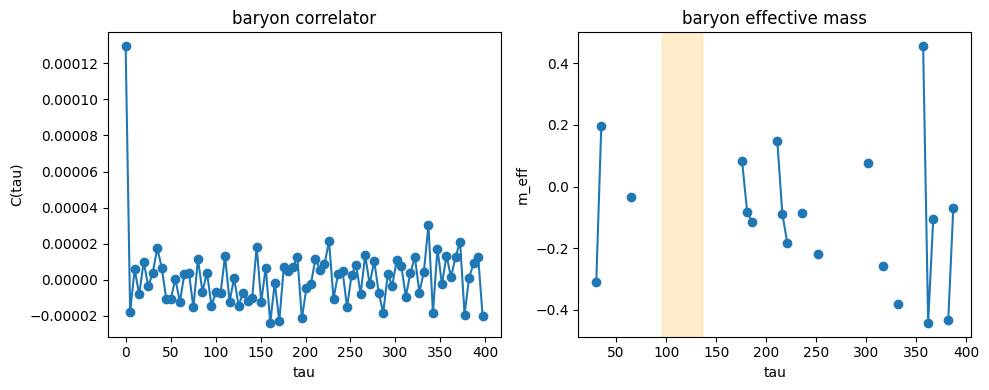

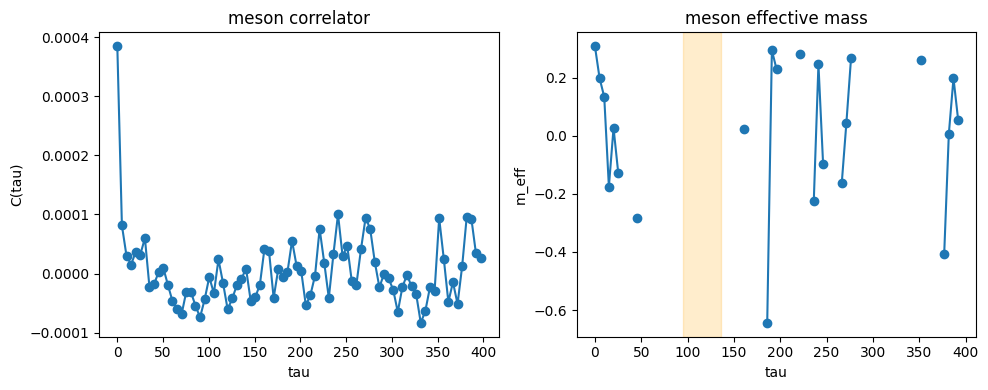

In [8]:
def _plot_effective_mass(op: str, fit_start: int, fit_stop: int) -> None:
    lags = arrays.get(f'particle_{op}_lags')
    eff = arrays.get(f'particle_{op}_eff_mass')
    corr = arrays.get(f'particle_{op}_corr')
    if lags is None or eff is None or corr is None:
        print(f'No arrays for {op}.')
        return

    n = min(len(lags), len(eff), len(corr))
    if n == 0:
        print(f'Empty arrays for {op}.')
        return
    lags = lags[:n]
    eff = eff[:n]
    corr = corr[:n]

    fit_start = max(0, min(fit_start, n - 1))
    fit_stop = max(fit_start + 1, min(fit_stop, n))

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(lags, corr, 'o-')
    ax[0].set_title(f'{op} correlator')
    ax[0].set_xlabel('tau')
    ax[0].set_ylabel('C(tau)')

    ax[1].plot(lags, eff, 'o-')
    ax[1].axvspan(lags[fit_start], lags[fit_stop - 1], color='orange', alpha=0.2)
    ax[1].set_title(f'{op} effective mass')
    ax[1].set_xlabel('tau')
    ax[1].set_ylabel('m_eff')
    plt.tight_layout()
    plt.show()


_plot_effective_mass('baryon', 19, 28)
_plot_effective_mass('meson', 19, 28)


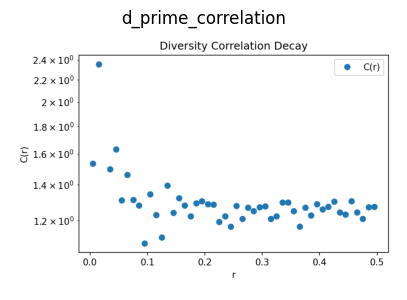

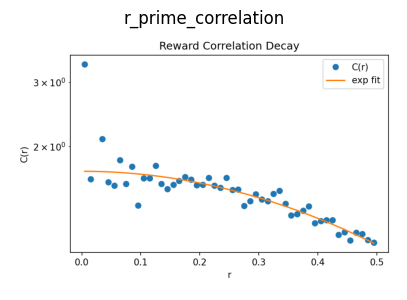

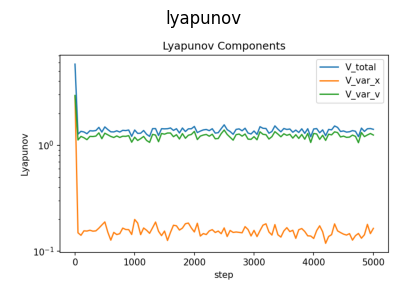

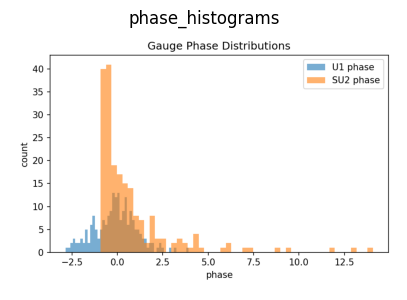

In [9]:
def show_saved_plot(label: str, path: str | None) -> None:
    if not path:
        return
    img = plt.imread(path)
    plt.figure(figsize=(5, 4))
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()


plots = metrics.get('plots', {})
for key in [
    'd_prime_correlation',
    'r_prime_correlation',
    'lyapunov',
    'phase_histograms',
    'wilson_histogram',
    'wilson_timeseries',
]:
    show_saved_plot(key, plots.get(key))

local_fields = plots.get('local_fields') or {}
for key, path in local_fields.items():
    show_saved_plot(f'local_{key}', path)
